In [1]:
# import libraries

# Install necessary libraries
!pip install scikit-learn imbalanced-learn

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedBaggingClassifier


In [2]:
# Load dataset
url = "/content/creditcard.csv"
data = pd.read_csv(url)

# Quick look
data.head()
data['Class'].value_counts()


,count
Class,
0.0,51440
1.0,150


In [4]:
#data preporcessing
# Features and Labels
X = data.drop(['Class', 'Time'], axis=1)  # Drop Time (often not useful here)
y = data['Class']

# Handle missing values in the target variable (y)
# You can either remove rows with missing values or impute them
# Here, we'll remove rows with missing values in 'Class'

y = y.dropna()  # drop the rows that contains NA values
X = X.loc[y.index] # select the rows from X that has the index of y after dropping the NA rows of y

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print("Training Samples:", X_train.shape[0])
print("Testing Samples:", X_test.shape[0])

Training Samples: 36113
Testing Samples: 15477


In [5]:
# undersampling to handle balance sample
# Apply random undersampling to balance the dataset
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

print("After Undersampling:", np.bincount(y_train_rus))


After Undersampling: [105 105]


In [6]:
# Train a basic Logistic Regression
lr = LogisticRegression(solver='liblinear', random_state=42)
lr.fit(X_train_rus, y_train_rus)

# Predict
y_pred = lr.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.963300381210829
ROC AUC: 0.9705179713150165
[[14865   567]
 [    1    44]]
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     15432
         1.0       0.07      0.98      0.13        45

    accuracy                           0.96     15477
   macro avg       0.54      0.97      0.56     15477
weighted avg       1.00      0.96      0.98     15477



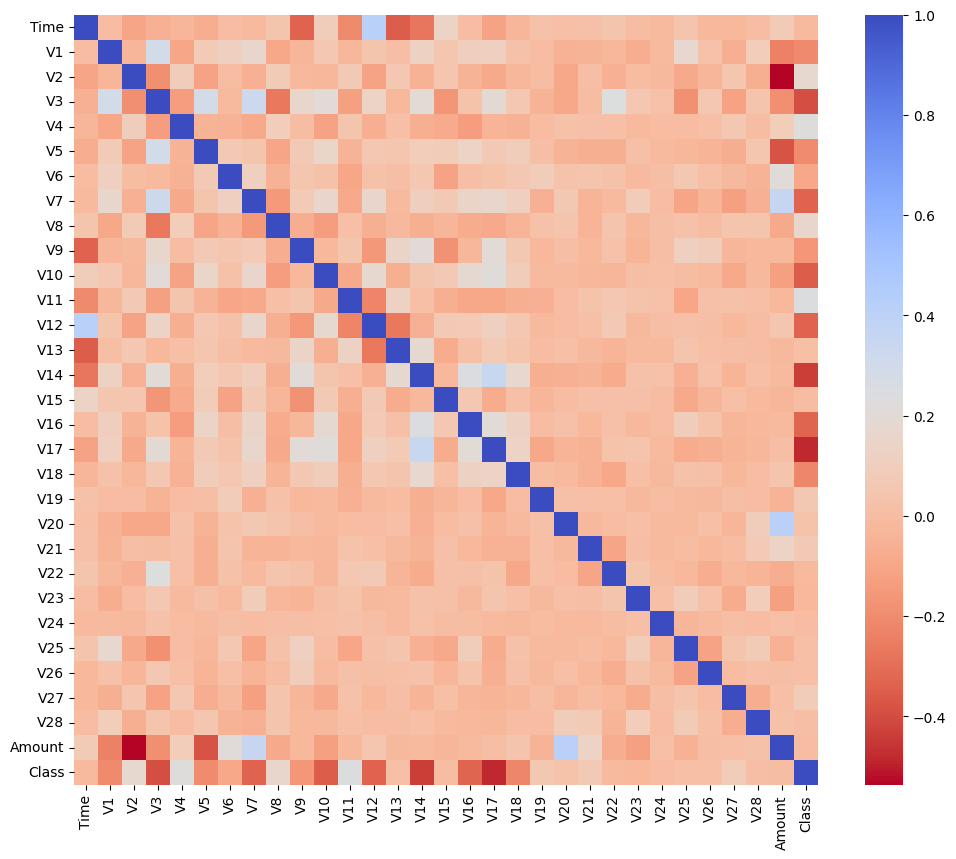

In [8]:
# feature engineering

# Correlation Heatmap
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), cmap='coolwarm_r')
plt.show()

# Optional: Remove features with low correlation with 'Class'
# Example: Keep only features V4, V11, V14, V17, V18 etc. if they show high correlation
important_features = ['V4', 'V11', 'V14', 'V17', 'V18', 'Amount']

# Ensure X_selected is created after handling missing values in 'y' and updating 'X'
X_selected = X[important_features] # Use the updated X with consistent rows

X_selected_scaled = scaler.fit_transform(X_selected)

# Train-test again
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_selected_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Undersample again
X_train_sel_rus, y_train_sel_rus = rus.fit_resample(X_train_sel, y_train_sel)

In [11]:
# hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_sel_rus, y_train_sel_rus)

print("Best Parameters:", grid.best_params_)
best_lr = grid.best_estimator_

# Predict
y_pred_best = best_lr.predict(X_test_sel)

# Evaluate
print("Tuned Accuracy:", accuracy_score(y_test_sel, y_pred_best))
print("Tuned ROC AUC:", roc_auc_score(y_test_sel, y_pred_best))
print(confusion_matrix(y_test_sel, y_pred_best))
print(classification_report(y_test_sel, y_pred_best))


Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Tuned Accuracy: 0.9782257543451574
Tuned ROC AUC: 0.978002419215483
[[15096   336]
 [    1    44]]
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     15432
         1.0       0.12      0.98      0.21        45

    accuracy                           0.98     15477
   macro avg       0.56      0.98      0.60     15477
weighted avg       1.00      0.98      0.99     15477



In [12]:
!pip install imbalanced-learn --upgrade
ensemble = BalancedBaggingClassifier(estimator=LogisticRegression(solver='liblinear'), # Use 'estimator' instead of 'base_estimator'
                                      sampling_strategy='auto',
                                      replacement=False,
                                      random_state=42)
ensemble.fit(X_train_sel, y_train_sel)

# Predict
y_pred_ensemble = ensemble.predict(X_test_sel)

# Evaluate
print("Ensemble Accuracy:", accuracy_score(y_test_sel, y_pred_ensemble))
print("Ensemble ROC AUC:", roc_auc_score(y_test_sel, y_pred_ensemble))
print(confusion_matrix(y_test_sel, y_pred_ensemble))
print(classification_report(y_test_sel, y_pred_ensemble))


Ensemble Accuracy: 0.9879821670866447
Ensemble ROC AUC: 0.9828948505270434
[[15247   185]
 [    1    44]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     15432
         1.0       0.19      0.98      0.32        45

    accuracy                           0.99     15477
   macro avg       0.60      0.98      0.66     15477
weighted avg       1.00      0.99      0.99     15477



In [13]:
#final evaluation
results = {
    "Model": ["Baseline LR", "Tuned LR", "Ensemble LR"],
    "Accuracy": [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test_sel, y_pred_best),
        accuracy_score(y_test_sel, y_pred_ensemble)
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_pred),
        roc_auc_score(y_test_sel, y_pred_best),
        roc_auc_score(y_test_sel, y_pred_ensemble)
    ]
}

results_df = pd.DataFrame(results)
print(results_df)



         Model  Accuracy   ROC AUC
0  Baseline LR  0.963300  0.970518
1     Tuned LR  0.978226  0.978002
2  Ensemble LR  0.987982  0.982895
